In [1]:
import os
import librosa # for speech
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing

In [2]:
#uploading the dataset file

from google.colab import files

uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [3]:
#unzipping the dataset file

import zipfile
import io

# Assuming 'Dataset.zip' is the uploaded file name
zip_ref = zipfile.ZipFile(io.BytesIO(uploaded['Dataset.zip']), 'r')
zip_ref.extractall('/content/')
zip_ref.close()


In [4]:
train_dir = '/content/train'


In [5]:
samples,sample_rate=librosa.load(train_dir + '/bed/35c8fa78_nohash_0.wav',sr=16000)
ipd.Audio(samples,rate=sample_rate)
print(sample_rate)

16000


In [6]:
samples=librosa.resample(y=samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples,rate=8000)

In [7]:
labels=os.listdir(train_dir)
no_of_recordings=[]
for label in labels:
  waves=[f for f in os.listdir(train_dir + '/' + label) if f.endswith('.wav')]
  no_of_recordings.append(len(waves))

labels=["bed","bird","cat","dog","down","eight"]

(array([1.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 1.000e+01, 1.300e+01,
        2.300e+01, 3.400e+01, 3.400e+01, 1.079e+03]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

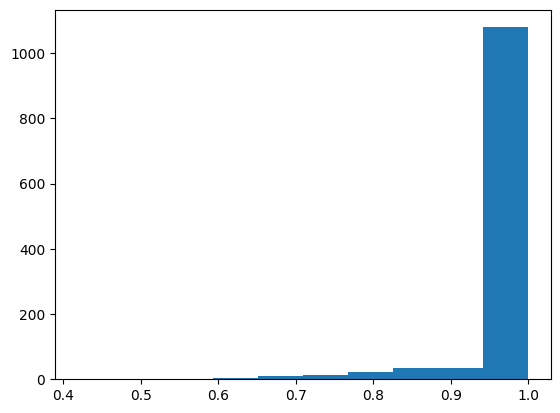

In [8]:
duration_of_recordings=[]
for label in labels:
  waves=[f for f in os.listdir(train_dir + '/' + label) if f.endswith('.wav')]
  for wav in waves:
    sample_rate,samples=wavfile.read(train_dir + '/' +label + '/' +wav)
    duration_of_recordings.append(float(len(samples)/sample_rate))

plt.hist(np.array(duration_of_recordings))

In [9]:
train_dir='train/'
all_wave=[]
all_label=[]
for label in labels:
  print(label)
  waves=[f for f in os.listdir(train_dir + '/' + label) if f.endswith('.wav')]
  for wav in waves:
    samples,sample_rate=librosa.load(train_dir + '/' + label + '/' + wav,sr=16000)
    samples=librosa.resample(y=samples,orig_sr=sample_rate,target_sr=8000)
    if (len(samples)==8000):
      all_wave.append(samples)
      all_label.append(label)

bed
bird
cat
dog
down
eight


In [10]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(all_label)
classes=list(le.classes_)
print(classes)

[np.str_('bed'), np.str_('bird'), np.str_('cat'), np.str_('dog'), np.str_('down'), np.str_('eight')]


In [11]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=len(labels))


In [12]:
all_wave=np.array(all_wave).reshape(-1,8000,1)

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size=0.2,random_state=777,shuffle=True)

In [14]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as k
k.clear_session()

inputs=Input(shape=(8000,1))

#1st layer
conv=Conv1D(8,13,padding='valid',activation='relu',strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#2nd layer
conv=Conv1D(16,11,padding='valid',activation='relu',strides=1)(conv)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#3rd layer
conv=Conv1D(32,9,padding='valid',activation='relu',strides=1)(conv)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#4th layer
conv=Conv1D(64,7,padding='valid',activation='relu',strides=1)(conv)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)

#flatten layer
conv=Flatten()(conv)

#dense layer 1
conv=Dense(256,activation='relu')(conv)
conv=Dropout(0.3)(conv)

#dense layer 2
conv=Dense(128,activation='relu')(conv)
conv=Dropout(0.3)(conv)

outputs=Dense(len(labels),activation='softmax')(conv)


model=Model(inputs,outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,982 (6.15 MB)

 Trainable params: 1,610,982 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10, min_delta=0.0001)
mc=ModelCheckpoint('voiceRecModel.keras',monitor='val_acc',verbose=1,save_best_only=True,mode='max')
print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)

(836, 8000, 1) (210, 8000, 1) (836, 6) (210, 6)


In [18]:
history=model.fit(x_train,y_train,epochs=50,callbacks=[es,mc],batch_size=8,validation_data=(x_val,y_val))

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.1719 - loss: 1.7974 - val_accuracy: 0.2095 - val_loss: 1.7900
Epoch 2/50


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_acc available.
  if self._should_save_model(epoch, batch, logs, filepath):


105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.1919 - loss: 1.7834 - val_accuracy: 0.2000 - val_loss: 1.7887
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.2106 - loss: 1.7841 - val_accuracy: 0.2619 - val_loss: 1.7762
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.1956 - loss: 1.7924 - val_accuracy: 0.1762 - val_loss: 1.7906
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.2251 - loss: 1.7659 - val_accuracy: 0.2333 - val_loss: 1.7500
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.2440 - loss: 1.7333 - val_accuracy: 0.2143 - val_loss: 1.7658
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.3063 - loss: 1.7181 - val_accuracy: 0.3143 - val_loss: 1.6040
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.3406 - loss: 1.6084 - val_accuracy: 0.3190 - val_loss: 1.5734
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.3592 - loss: 1.5993 - val_accur

In [19]:
model.save('voiceRecModel.keras')

In [22]:
from keras.models import load_model
model=load_model('voiceRecModel.keras')

In [23]:
def predict(audio):
  prob=model.predict(audio.reshape(1,8000,1))
  index=np.argmax(prob[0])
  return classes[index]


import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples,rate=8000)

Audio: eight


In [24]:
print('Text:',predict(samples))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Text: eight


In [25]:
import time
from google.colab import files

model.save('voiceRecModel.keras')  # or your model filename and format
time.sleep(5)  # wait to ensure file is saved completely
files.download('voiceRecModel.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>